# Testing For Autoregressive Moving average models

In this notebook we will build two time series models. The Autoregresssive model with leg p (AR(p)) and the Moving Average model with leg q (MA(q)). 

Then, we will use some the statsmodel module to test a time series for its parameters and find its parameters. 

Finally, we will try the same tools in real market data to understand its shortcomings.

This notebook is inspired by an R notebook from the MIT Micro Masters in Finance (MITx 15.455x - Mathematical Methods for Quantitative Finance)

In [304]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Autoregressive model

First let's build a class to generate an Autoregressive time series

In [567]:
class AR:
  def __init__(self, cs, sigma):
    """
    cs - list: List os constants Cs for Autoregressive formula of the form
    
    r_t = cs[0] + cs[1]*r[t-1] ... cs[-1]*r[-1] + sigma*z
    Where z ~ N(0,1)
    """
    self._cs = cs
    self.sigma = sigma
    self.hist = np.array([])

  def __call__(self, steps):
    # Time flows down top to bottom
    # paths from from left to right
    self.R = np.zeros((steps,)) # rows, columns
    Zt = np.random.normal(size=(steps,))
    for i in range(len(self._cs)-1, steps):
      C = np.array(self._cs + [Zt[i]])
      r = [1] + [self.R[i-j-1] for j in range(len(self._cs)-1 )] + [self.sigma]
      #print(i, [self.R[i-j-1] for j in range(len(self._cs)-1 )], r)
      self.R[i] = sum(C*r)
      #print(f"{self.R = }")
    
  def plot(self):
    plt.plot(np.cumsum(self.R))

In [ ]:
# Let's set the see and run a series with the following parameters
np.random.seed(41)
ar = AR([0.001, -0.1, 0.4], 1)
ar(10000)

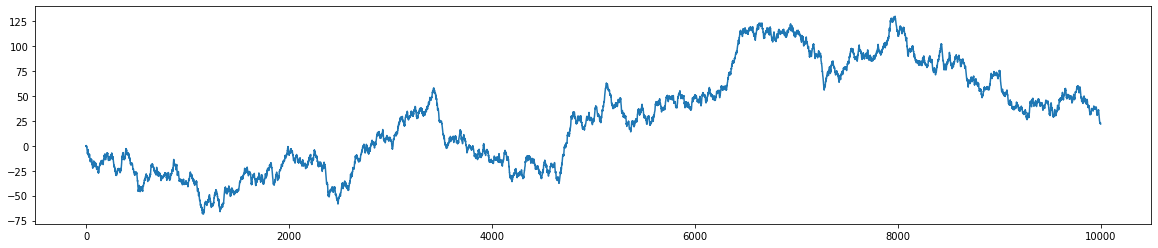

In [554]:
ar.plot()

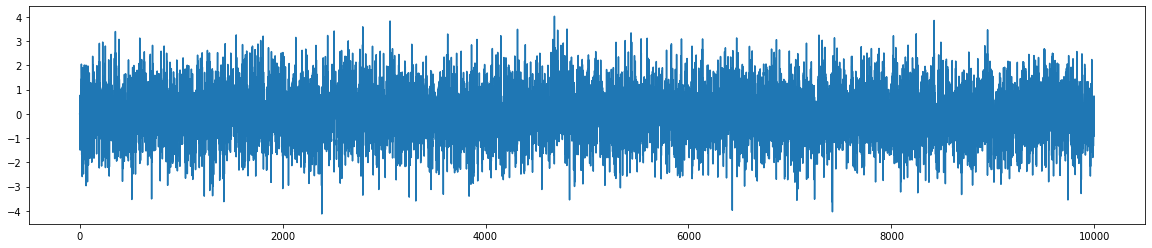

In [555]:
plt.plot(ar.R)

## Autocorrelation and Partial Autocorrelation Functions (ACF)/(PACF)

Now that we created a time series, let's plot the correlation between time `t` its lags. 
The goal is to find in which lag the correlation vanishes. 

Since we constructed this time series with an AR(2), we should see the correlation up to the second lag. 

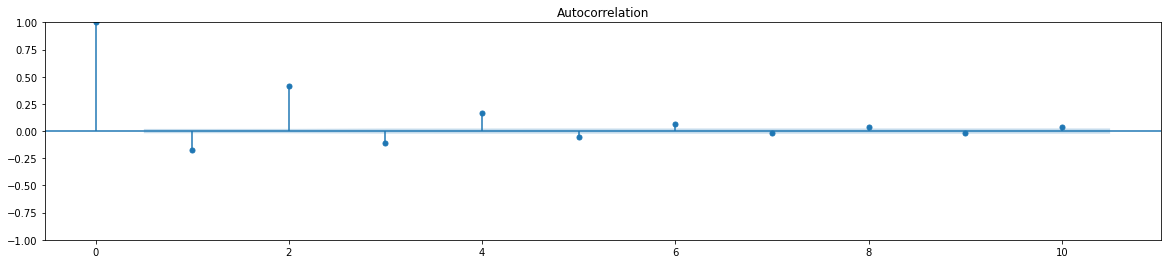

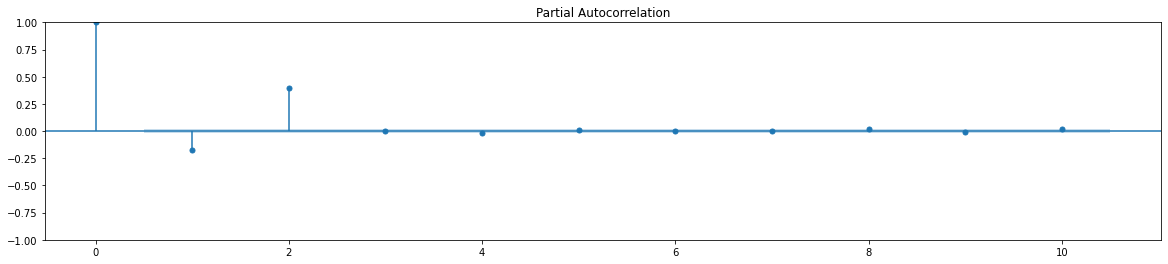

In [556]:
_ = sm.graphics.tsa.plot_acf(ar.R, lags=10)
_ = sm.graphics.tsa.plot_pacf(ar.R, lags=10, method='ywm')

See above in the ACF plot (top plot) the correlation vanishing slowly from the lag's zero to lag two, four and six. Why is that? The issue here that the correlation persists overtime, and as depicted in the plot, it vanishes slowly for AR models. To solve that issue, the Partial Autocorrelation function (PACF) can be used to clearly show the maximum lag in which the correlation is still significant (lag two as we can see in the bottom plot)

### Fitting the parameters

Now that we got our time series, found its lag, it is time to calibrate its parameters.
For that we will use the module `statsmodels`.

In [569]:
# The parameters that we input to generate the data
ar._cs

[0.001, -0.1, 0.4]

In [570]:
# Let's try to fit an AR(3) and see which problems we can spot
mod = sm.tsa.arima.ARIMA(ar.R, order=(3, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -14278.378
Date:                Sun, 16 Oct 2022   AIC                          28566.757
Time:                        22:03:23   BIC                          28602.808
Sample:                             0   HQIC                         28578.960
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.014      0.151      0.880      -0.026       0.030
ar.L1         -0.1061      0.010    -10.505      0.000      -0.126      -0.086
ar.L2          0.3972      0.009     43.710      0.0

**How to read the table:**
- Coef: The coefficients for the models are unde the `coef` column. 
    - Note `ar.L1` and `ar.L2` equal to -0.1061 and 0.3972, close the given parameters -0.1 and 0.4
    - Note that `ar.L3` given is 0.0027, but it is not significantly different than zero
- p-value and significance:
    - Note that the column `P>|z|` gives the p-value for the following null-hypothesis test:
        - $H_0:  \text{coef} = 0$
        - $H_A: \text{coef} \neq 0$
    - The p-value for `ar.L3` is 0.790, i.e., if the null-hypothesis is true, there is a 79% chance to observe the data, hence we do not have enough evidence to reject $H_0$. 
    - On the other hand, the p-values for `ar.L1` and `ar.L2` are less than 0.001. Hence, we can reject the null-hypothesis that `ar.L1` and `ar.L2` are equal to zero.

# Testing Moving Average model

Let's do the same steps we've done for Autoregressive models but for Moving Average models

In [560]:
import statsmodels.api as sm

class MA:
  def __init__(self, phis, mu, sigma):
    """
    phis - list: List os constants Phis for Moving Average formula of the form
    
    r_t = mu + sigma*z[t] + phi[0] * z[t] + phi[1] * z[t-1] + phi[2] * z[t-2] + ...
    Where z ~ N(0,1)
    """
    self._phis = phis
    self.sigma = sigma
    self.mu = mu
    self.hist = np.array([])

  def __call__(self, steps):
    # Time flows down top to bottom
    # paths from from left to right
    self.R = np.zeros((steps,)) # rows, columns
    Zt = np.random.normal(size=(steps,))
    self.R[0] = self.mu + self.sigma * Zt[0]
    self.R[1] = self.mu + self.sigma * Zt[1] + self._phis[0] * Zt[0]
    PHI = np.array([self.mu] + [self.sigma] + self._phis)

    for i in range(len(self._phis)-1, steps):
      z = [1] + [Zt[i-j] for j in range(len(self._phis)+1)][::-1]
      #print(i, z, Zt)
      self.R[i] = sum(PHI*z)
    
  def plot(self):
    plt.plot(np.cumsum(self.R))

np.random.seed(41)
ma = MA(phis=[0.001, -0.1, 0.4], mu=0, sigma=1)
ma(1000)

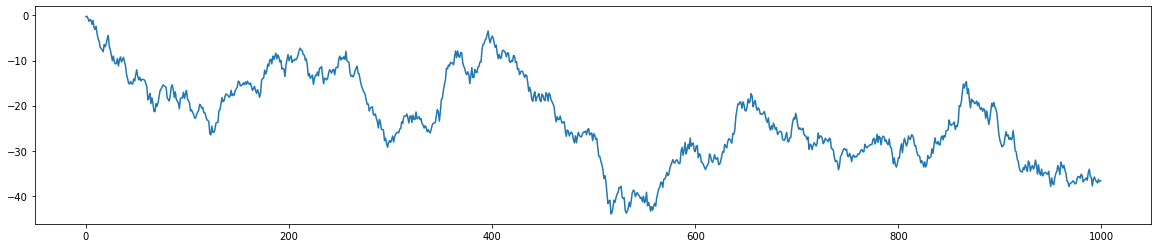

In [561]:
ma.plot()

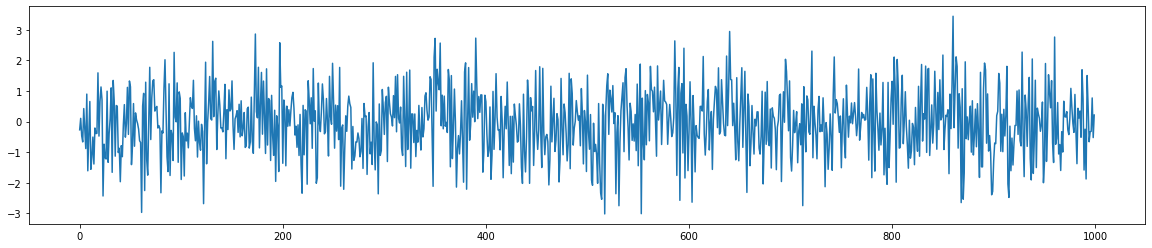

In [562]:
plt.plot(ma.R)

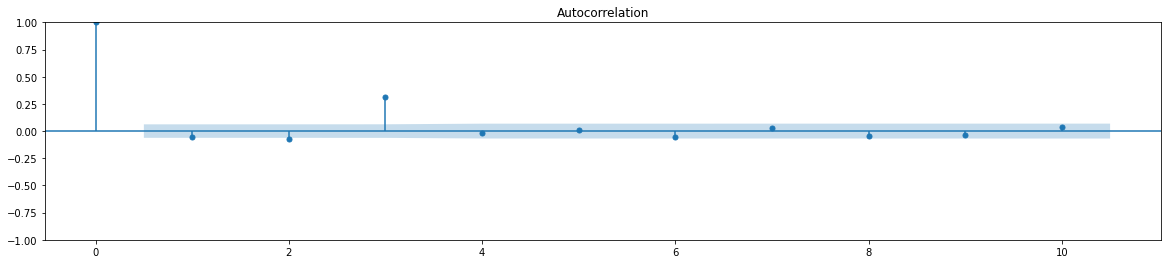

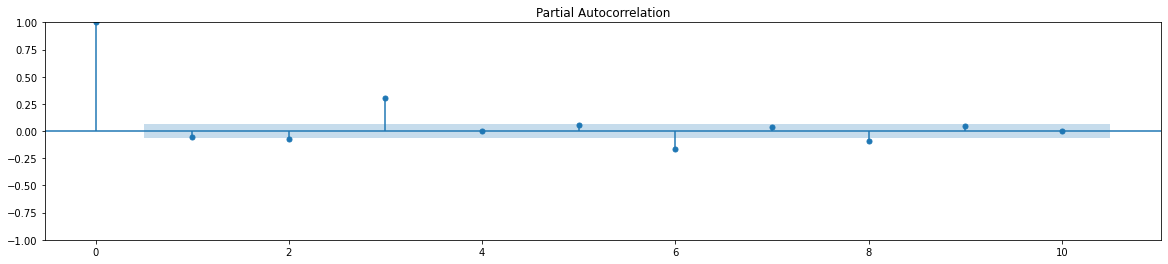

In [563]:
_ = sm.graphics.tsa.plot_acf(ma.R, lags=10)
_ = sm.graphics.tsa.plot_pacf(ma.R, lags=10, method='ywm')

In [565]:
ma._phis

[0.001, -0.1, 0.4]

In [566]:
mod = sm.tsa.arima.ARIMA(ma.R, order=(0, 0, 3))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1419.520
Date:                Sun, 16 Oct 2022   AIC                           2849.040
Time:                        21:15:20   BIC                           2873.579
Sample:                             0   HQIC                          2858.366
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0366      0.040     -0.910      0.363      -0.116       0.042
ma.L1         -0.0089      0.028     -0.313      0.755      -0.064       0.047
ma.L2         -0.1060      0.028     -3.763      0.0

# Market Data

In [571]:
# We wil download data from yahoo finance, uncomment the following lines if you do not have these modules installed
# !pip install yfinance

import pandas as pd
import yfinance as yf

Let's look at our favorite stock (Tootsie Roll). 
We already know it is not a random walk (see [here](https://github.com/mauhcs/quant-finance/blob/main/notebooks/Are%20Stock%20Prices%20A%20Random%20Walk%3F%20(Andrew%20W.%20Lo%2C%20A.%20Craig%20MacKinlay%2C%201988).ipynb)), can we try to fit another time series model, then?  

In [572]:
ticker_name = "TR" # Change here for any Ticker name you wanna check yourself
data = yf.download(ticker_name)

_filter = data.index > "1987-12-31"
_filter &= data.index <= "2017-12-31"

data = data[_filter].copy()

[*********************100%***********************]  1 of 1 completed


In [573]:
r = np.log(data["Adj Close"]).diff().dropna() # get the log returns 

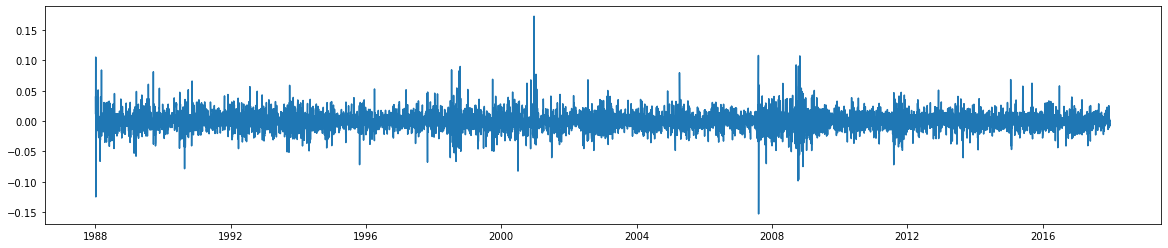

In [574]:
plt.plot(r)

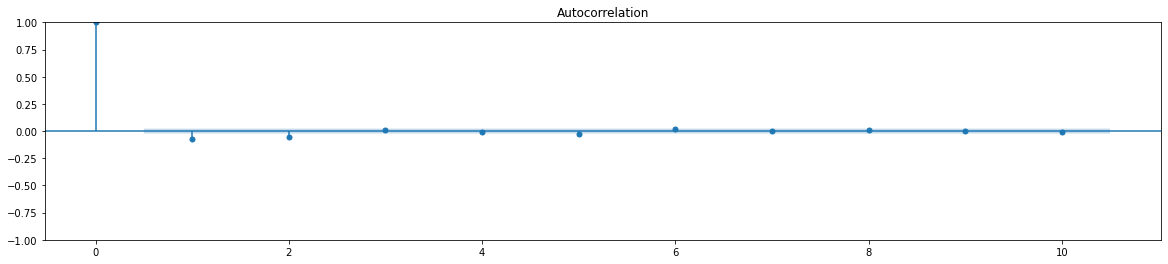

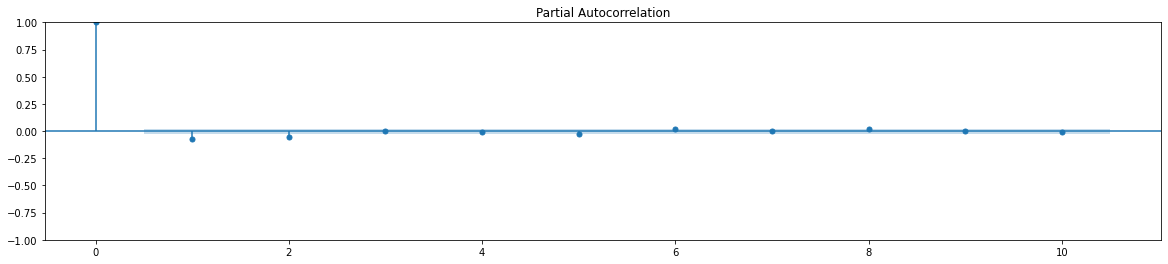

In [575]:
_ = sm.graphics.tsa.plot_acf(r, lags=10)
_ = sm.graphics.tsa.plot_pacf(r, lags=10, method='ywm')

In [576]:
mod = sm.tsa.arima.ARIMA(r.values, order=(0, 0, 2))
res = mod.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7560
Model:                 ARIMA(0, 0, 2)   Log Likelihood               20923.450
Date:                Sun, 16 Oct 2022   AIC                         -41838.899
Time:                        22:13:20   BIC                         -41811.177
Sample:                             0   HQIC                        -41829.383
                               - 7560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.088      0.037    1.98e-05       0.001
ma.L1         -0.0700      0.008     -9.033      0.000      -0.085      -0.055
ma.L2         -0.0520      0.007     -7.287      0.0

### Discussion
At a first glance it seems we could fit MA(2) model to the market data. It would be interesting to try and do some predictions.